In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

**Load data**

In [ ]:
# Load Excel files
order_report = pd.read_excel("Company X - Order Report.xlsx")
sku_master = pd.read_excel("Company X - SKU Master.xlsx")
pincode_zones = pd.read_excel("Company X - Pincode Zones.xlsx")
courier_invoice = pd.read_excel("Courier Company - Invoice.xlsx")
rate_card = pd.read_excel("Courier Company - Rates.xlsx")

Step 3: ***Clean Column Names ***

Make sure column names match your logic. E.g., rename ExternOrderNo to Order ID:

In [ ]:
order_report.rename(columns={'ExternOrderNo': 'Order ID'}, inplace=True)

In [ ]:
print(order_report.head())
print(sku_master.head())
print(pincode_zones.head())
print(courier_invoice.head())
print(rate_card.head())



     Order ID            SKU  Order Qty
0  2001827036  8904223818706        1.0
1  2001827036  8904223819093        1.0
2  2001827036  8904223819109        1.0
3  2001827036  8904223818430        1.0
4  2001827036  8904223819277        1.0
             SKU  Weight (g)
0  8904223815682         210
1  8904223815859         165
2  8904223815866         113
3  8904223815873          65
4  8904223816214         120
   Warehouse Pincode  Customer Pincode Zone
0             121003            507101    d
1             121003            486886    d
2             121003            532484    d
3             121003            143001    b
4             121003            515591    d
        AWB Code    Order ID  Charged Weight  Warehouse Pincode  \
0  1091117222124  2001806232            1.30             121003   
1  1091117222194  2001806273            1.00             121003   
2  1091117222931  2001806408            2.50             121003   
3  1091117223244  2001806458            1.00          

Merge Order report with SKU Weights

In [ ]:
order_with_weights = pd.merge(order_report,sku_master,on='SKU',how='left')

In [ ]:
order_with_weights.head()

,Order ID,SKU,Order Qty,Weight (g)
0,2001827036,8904223818706,1.0,127
1,2001827036,8904223819093,1.0,150
2,2001827036,8904223819109,1.0,100
3,2001827036,8904223818430,1.0,165
4,2001827036,8904223819277,1.0,350


Calculate Total Weight per Order

In [ ]:
order_weight = order_with_weights.groupby('Order ID')['Weight (g)'].sum().reset_index()
order_weight['Weight (kg)'] = order_weight['Weight (g)']/1000
print(order_weight)

order_weight['Weight Slab (kg)'] = order_weight['Weight (kg)'].apply(lambda x: math.ceil(x))
print(order_weight)

       Order ID  Weight (g)  Weight (kg)
0    2001806210         220        0.220
1    2001806226         240        0.240
2    2001806229         500        0.500
3    2001806232         377        0.377
4    2001806233         245        0.245
..          ...         ...          ...
119  2001821995         477        0.477
120  2001822466         352        0.352
121  2001823564         336        0.336
122  2001825261         611        0.611
123  2001827036        2039        2.039

[124 rows x 3 columns]
       Order ID  Weight (g)  Weight (kg)  Weight Slab (kg)
0    2001806210         220        0.220                 1
1    2001806226         240        0.240                 1
2    2001806229         500        0.500                 1
3    2001806232         377        0.377                 1
4    2001806233         245        0.245                 1
..          ...         ...          ...               ...
119  2001821995         477        0.477                 1
120  2001822

merge with courier invoice

In [ ]:
invoice_merged = pd.merge(courier_invoice,order_weight,on = 'Order ID', how='left')
invoice_merged.head()

,AWB Code,Order ID,Charged Weight,Warehouse Pincode,Customer Pincode,Zone,Type of Shipment,Billing Amount (Rs.),Weight (g),Weight (kg),Weight Slab (kg)
0,1091117222124,2001806232,1.30,121003,507101,d,Forward charges,135.0,377,0.377,1
1,1091117222194,2001806273,1.00,121003,486886,d,Forward charges,90.2,615,0.615,1
2,1091117222931,2001806408,2.50,121003,532484,d,Forward charges,224.6,929,0.929,1
3,1091117223244,2001806458,1.00,121003,143001,b,Forward charges,61.3,700,0.700,1
4,1091117229345,2001807012,0.15,121003,515591,d,Forward charges,45.4,240,0.240,1


Add Delivery Zone from Pincode


In [ ]:
# Rename zone column to be clear in the final output
pincode_zones = pincode_zones.rename(columns={'Zone': 'Zone as per X'})

# Merge on Customer Pincode: invoice uses 'Customer Pincode_x'
invoice_merged = pd.merge(
    invoice_merged,
    pincode_zones[['Customer Pincode', 'Zone as per X']],
    left_on='Customer Pincode_x',
    right_on='Customer Pincode',
    how='left'
)


In [ ]:
pincode_zones.columns

Index(['Warehouse Pincode', 'Customer Pincode', 'Zone'], dtype='object')

Calculate expected charges from rate card


In [ ]:
rate_card.columns

Index(['fwd_a_fixed', 'fwd_a_additional', 'fwd_b_fixed', 'fwd_b_additional',
       'fwd_c_fixed', 'fwd_c_additional', 'fwd_d_fixed', 'fwd_d_additional',
       'fwd_e_fixed', 'fwd_e_additional', 'rto_a_fixed', 'rto_a_additional',
       'rto_b_fixed', 'rto_b_additional', 'rto_c_fixed', 'rto_c_additional',
       'rto_d_fixed', 'rto_d_additional', 'rto_e_fixed', 'rto_e_additional'],
      dtype='object')

In [ ]:
print(invoice_merged.columns.tolist())


['AWB Code', 'Order ID', 'Charged Weight', 'Warehouse Pincode_x', 'Customer Pincode_x', 'Zone', 'Type of Shipment', 'Billing Amount (Rs.)', 'Weight (g)', 'Weight (kg)', 'Weight Slab (kg)', 'Warehouse Pincode_y', 'Customer Pincode_y']


In [ ]:

# ✅ 3. Define function to calculate expected charge from the rate card columns
def calculate_expected_charge(row):
    shipment_type = row['Type of Shipment']
    zone = str(row['Zone as per X']).lower()
    weight_slab = row['Weight Slab (kg)']

    if pd.isna(zone) or pd.isna(weight_slab):
        return np.nan
    if shipment_type == 'Forward charges':
        fixed_col = f'fwd_{zone}_fixed'
        add_col = f'fwd_{zone}_additional'
    elif shipment_type == 'Forward and RTO charges':
        fixed_col = f'rto_{zone}_fixed'
        add_col = f'rto_{zone}_additional'
    else:
        return np.nan
    try:
        fixed = rate_card[fixed_col].values[0]
        additional = rate_card[add_col].values[0]
        extra_units = max(0, (weight_slab - 0.5) / 0.5)
        return round(fixed + extra_units * additional, 2)
    except KeyError:
        print(f"Rate card column missing: {fixed_col} or {add_col}")
        return np.nan
    except Exception as e:
        print(f"Error calculating charge for Order ID {row['Order ID']}: {e}")
        return np.nan
invoice_merged['Expected Charge (Rs.)'] = invoice_merged.apply(calculate_expected_charge, axis=1)


In [ ]:
# Step 9 – Calculate difference between expected and billed charges
invoice_merged['Charge Difference'] = invoice_merged['Expected Charge (Rs.)'] - invoice_merged['Billing Amount (Rs.)']

# Step 9 – Classify charge status based on difference
def classify_charge(diff):
    if abs(diff) < 1:
        return 'Correct'
    elif diff < 0:
        return 'Overcharged'
    else:
        return 'Undercharged'

invoice_merged['Charge Status'] = invoice_merged['Charge Difference'].apply(classify_charge)


In [ ]:
# Step 10 – Summary table of charge status
summary = invoice_merged.groupby('Charge Status').agg({
    'Order ID': 'count',
    'Billing Amount (Rs.)': 'sum',
    'Charge Difference': 'sum'
}).rename(columns={
    'Order ID': 'Count',
    'Billing Amount (Rs.)': 'Total Charged',
    'Charge Difference': 'Total Difference'
}).reset_index()


In [ ]:
# Step 11 – Save full comparison and summary report
invoice_merged.to_excel("Order_Level_Details.xlsx", index=False)
summary.to_excel("Summary_Report.xlsx", index=False)


In [ ]:
pd.read_excel("/content/Summary_Report.xlsx")

,Charge Status,Count,Total Charged,Total Difference
0,Correct,1319,105235.5,0.0
1,Overcharged,4449,571289.0,-262080.1
2,Undercharged,2012,109822.8,82551.4


<ipython-input-39-bc682f9f7382>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Charge Status', data=invoice_merged, palette='Set2')


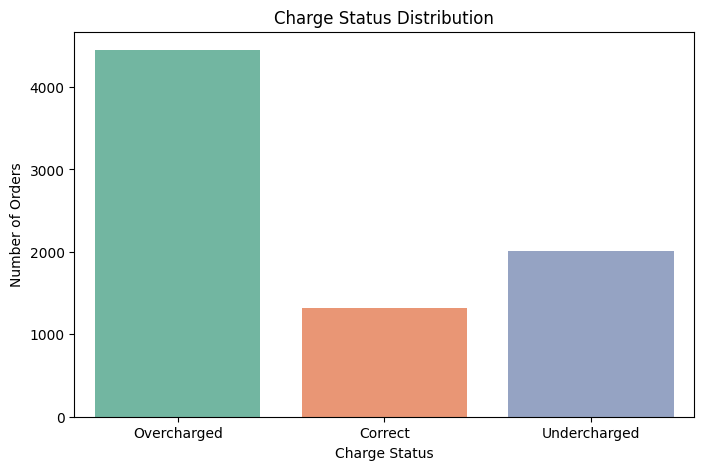

In [ ]:
# 1. Charge Status Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Charge Status', data=invoice_merged, palette='Set2')
plt.title("Charge Status Distribution")
plt.xlabel("Charge Status")
plt.ylabel("Number of Orders")
plt.savefig("charge_status_distribution.png")

<ipython-input-40-ea9d16e2e8a7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=invoice_merged, x='Zone as per X', y='Charge Difference', palette='Set3')


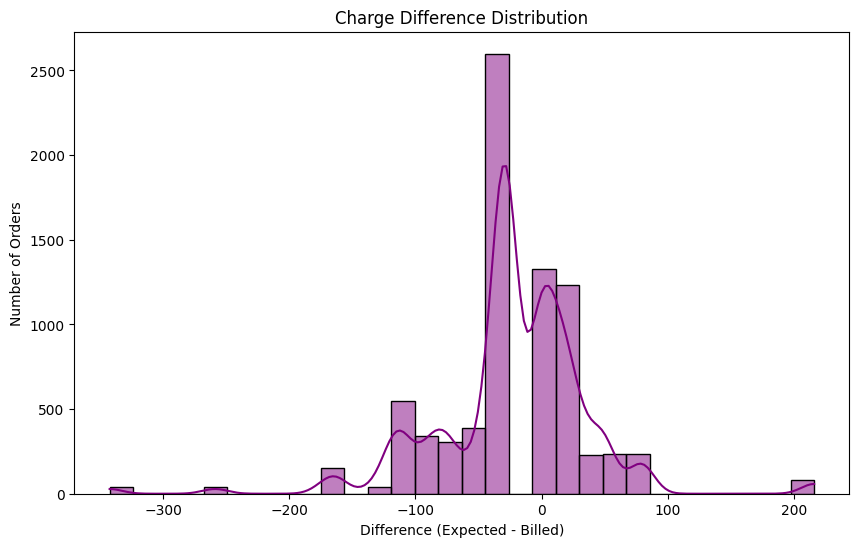

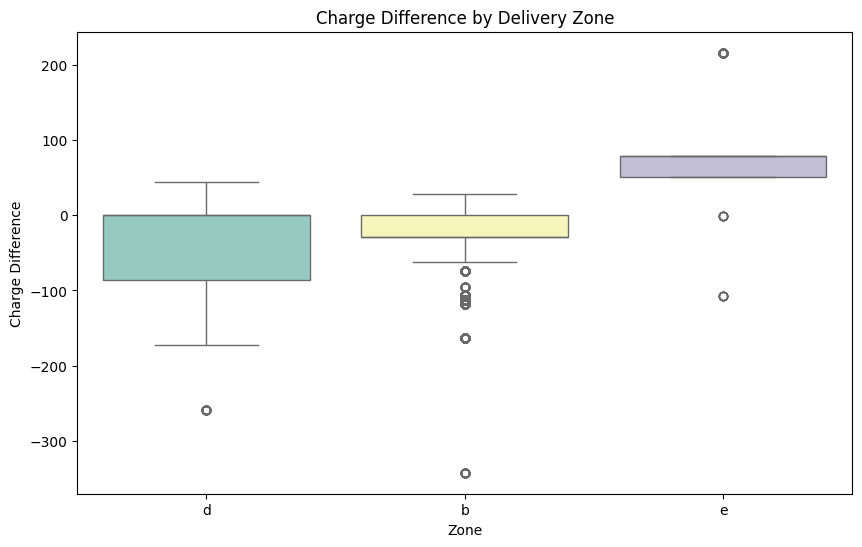

In [ ]:
# 2. Histogram of Charge Differences
plt.figure(figsize=(10, 6))
sns.histplot(invoice_merged['Charge Difference'], bins=30, kde=True, color='purple')
plt.title("Charge Difference Distribution")
plt.xlabel("Difference (Expected - Billed)")
plt.ylabel("Number of Orders")
plt.savefig("charge_difference_histogram.png")

# 3. Boxplot of Charge Difference by Zone
plt.figure(figsize=(10, 6))
sns.boxplot(data=invoice_merged, x='Zone as per X', y='Charge Difference', palette='Set3')
plt.title("Charge Difference by Delivery Zone")
plt.xlabel("Zone")
plt.ylabel("Charge Difference")
plt.savefig("zone_wise_charge_difference.png")